In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab03.ipynb")

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.api import OLS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Lab 3: Wrangling Survey Data

This lab uses a real-world dataset from the Rurals Water Project Spring Protection Study, collected by Innovations for Poverty Action in 2008. Professor Van Dusen was working as a Research Manager on the project at the time, and this is some of the follow-up work done after the main study.

Part of this study was included in a Journal Article called [_Being Surveyed Can Change Later Behaviour and Related Parameter Estimates_](https://www.pnas.org/doi/epdf/10.1073/pnas.1000776108), published in the Proceedings of the National Academy of Science (PNAS). A summary of the work related to this notebook is contained in this [unpublished draft](https://berkeley.box.com/s/epj41ofw9bph99dim92dsa69gj17puul). 

In this project, there are two datasets from repeated visits to the same households. One of the datasets is at the household-level, and the other one is at the child-level (where there can be multiple children within a given household). Before embarking on the lab, make sure you understand the overall structure of the [survey](https://berkeley.app.box.com/s/2thnb8dan58o7w44mu9tpk1zy8l4c0no); it will be very helpful.

### Learning Objectives:
- Perform an EDA of the Main Rural Project Spring Protection Study, a real-world developmental economics research project
- Understand a complex survey
- Understand the Hawthorne effect and finds empirical evidence
- Analyzes survey data using Pandas tools we have learned so far

---
## Phase 1: Explorative Data Analysis (EDA)

Let's start off with loading in the dataset. Similar to many academic datasets, our dataset is stored in a Stata .dta file.

**Question 1.1:** Load in the stata dataset `BWM_child_EVDvars.dta` and read it into a Pandas dataframe. Name it `wg_df`.

Hint: Check out this [Pandas documentation](https://pandas.pydata.org/docs/user_guide/io.html) to see how to read in different types of files. 

In [5]:
wg_df = pd.read_stata("BWM_child_EVDvars.dta")
wg_df.head()

,a1_hh_id,a2_spring_id,bwm_round,quiz_id,child_id,child_observed,order_c,c3_1_child_id,c3_2a_name1,c3_2b_name2,...,assWG8,assWG9,assWG10,assWG11,assWG12,assWG13,assWG14,assWG15,MainBWM,round9
0,11006,11,1,1105,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1,11006,11,2,2135,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
2,11006,11,3,3141,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3,11006,11,4,4099,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
4,11006,11,5,5107,04,1,NaN,NaN,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [6]:
grader.check("q1_1")

q1_1 results: All test cases passed!

**Question 1.2:** Using the `shape` attribute, find the structure of the `wg_df` dataframe. How many rows and columns are there in the dataframe? Assign the values to the corresponding variables `N_rows` and `N_cols`. 

In [7]:
N_rows = wg_df.shape[0]
N_cols = wg_df.shape[1]
N_rows, N_cols

(7782, 224)

In [8]:
grader.check("q1_2")

q1_2 results: All test cases passed!

**Granularity**: Now, let's focus on the granularity of the dataset. We define this as the level of aggregation in our data. 

- For geospatial data, think of data summarized over city, block, street, building, address, room number etc. as increasing level of granularity. 

- For time series data, granularity could for instance be weekly, daily, hourly averages of a variable. 

Survey data might be a bit trickier to entangle, but we're certain you got this!

<!-- BEGIN QUESTION -->

**Question 1.3:** What is the granularity of our dataset? Think about what each row represents. Choose 3 arbitrary columns you find interesting and explain how they help you understand the dataset's granularity. One of them should identify the *primary key* of this dataset. (Note that the primary key can be a combination of 2 or more columns.)

Hint: You can use [`pandas.Series.value_counts`](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and/or [`pandas.Series.unique`](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html).

In [12]:
len(wg_df["quiz_id"].unique())

3040

<!-- END QUESTION -->

**Question 1.4** How many unique households and springs are there in this dataset? How many rounds of interviews were held? Assign the values to the corresponding variables. 

*Hint:* `a1_hh_id` is the household ID. `a2_spring_id` is the spring ID. `bwm_round` specifies the round of interview. 

In [16]:
num_households = len(wg_df["a1_hh_id"].unique())
num_springs = len(wg_df["a2_spring_id"].unique())
num_interview_rounds = len(wg_df["bwm_round"].unique())

print('Households: ', num_households)
print('Springs: ', num_springs)
print('Interview Rounds: ', num_interview_rounds)

Households:  320
Springs:  72
Interview Rounds:  20


In [17]:
grader.check("q1_4")

q1_4 results: All test cases passed!

---
## Phase 2: Understanding the Survey

Our EDA in Phase 1 helped us understand the general structure of the data. Now, turn to the [survey PDF](https://berkeley.app.box.com/s/2thnb8dan58o7w44mu9tpk1zy8l4c0no). Glance over it and try to put yourself in the shoes of the interviewer and answer the questions below. Throughout this lab, you might find it helpful to refer to [Appendix 1](#appendix_1) which connect the relevant survey sections with columns in our dataset.

<!-- BEGIN QUESTION -->

**Question 2.1:** What are the main parts of the survey? In this question, list out only the sections A, D, E, and G denoted by a letter and explain in 1 sentence what you believe to be its significance. We'll start you off with two:

- Section A: Introduction with general respondent and interview round information and consent. 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2.2:** Outside of the paper's "sphere of research interest", what would be interesting datapoints to analyse further? This is an open-ended question, and we suggest you form a short research question and how you would use the data from the survey.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

---
## Phase 3: Analyzing Disease Prevalence Across Survey Rounds

As we've learned from our EDA and analyzing the survey itself, we understand that our dataset is the result of a series of survey rounds (20 in total). A series of households were interviewed, asked primarily about the general health condition of children in the household over the past week. If a child was ill on the survey day, it was examined further for the symptoms of diarrhea. We now direct our focus to the result of **section D: The Health History tables** (starting Page 7 in the [survey](https://berkeley.app.box.com/s/2thnb8dan58o7w44mu9tpk1zy8l4c0no)) - one filled out for each child in the household per survey round. During the following questions, we suggest you **keep a close eye on the survey.**

**Question 3.1:** How many households were surveyed each round? Assign the result to a dataframe `grouped_by_round` with only two columns `bwm_round` and `count`. For now, exclude the survey rounds denoted 99 and 161.

In [27]:
relevant_rounds = wg_df[(wg_df["bwm_round"] != 99) & (wg_df["bwm_round"] != 161)] 
grouped_by_round = (relevant_rounds.groupby("bwm_round")["bwm_round"].count()).reset_index(name="count")
grouped_by_round.head()

,bwm_round,count
0,1,377
1,2,373
2,3,375
3,4,382
4,5,418


In [28]:
grader.check("q3_1")

q3_1 results: All test cases passed!

We can plot the data using a bar chart, as done below.

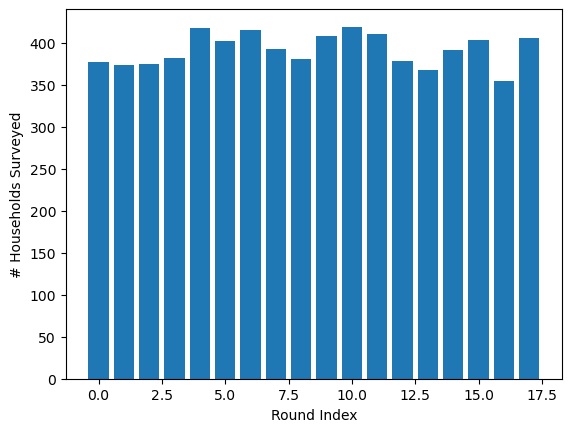

In [29]:
plt.bar(grouped_by_round.index,grouped_by_round['count']);
plt.xlabel("Round Index")
plt.ylabel("# Households Surveyed");

<!-- BEGIN QUESTION -->

**Question 3.2**: Discuss the plot and describe one potential cause for the variation in the number of participating households across rounds. 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

#### Rounds 99 and 161

During the survey, a decision was made to survey an additional set of households that were not being surveyed as frequently. Round 99 happened at the same time as round 9 as a new control group of households, and round 161 happened at the same time as round 16.

In other words, the researchers added a control group that was "less frequently surveyed". These households reported much higher diarrhea prevalence. We later use these extra-rounds to quantify the [Hawthorne effect](https://en.wikipedia.org/wiki/Hawthorne_effect) discussed in lecture.

**Question 3.3**: We now turn our attention to the variable of interest: The 7-day recall variable for diarrhea in the past week, denoted `d6a1_7dd_n` in the dataset. It is a binary categorical variable: 1 if a surveyed child in a given household had diarrhea the past 7 days, 0 if not. In the code cell below, generate a **Series** with the number of households that did/didn't have children with diarrhea in the past 7 days.

Hint: One way to generate a series is to use `.groupby` and attach a relevant function. 

In [38]:
diarrhea_groups = relevant_rounds.groupby("d6a1_7dd_n")["a1_hh_id"].count()
diarrhea_groups

d6a1_7dd_n
0.0    6525
1.0     526
Name: a1_hh_id, dtype: int64

In [39]:
grader.check("q3_3")

q3_3 results: All test cases passed!

We plot the data using a bar chart once again.

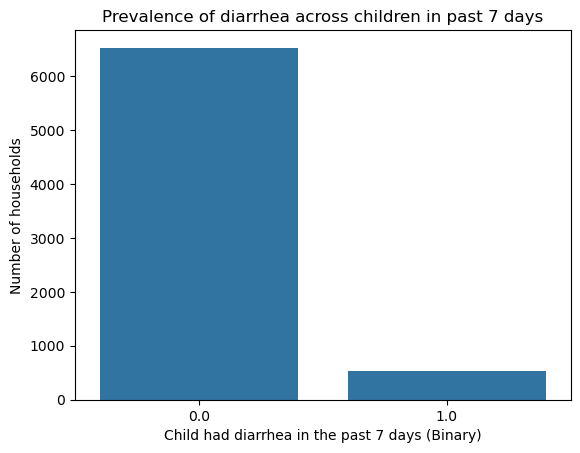

In [40]:
ax = sns.barplot(x=diarrhea_groups.index, y=diarrhea_groups.values);
ax.set(xlabel='Child had diarrhea in the past 7 days (Binary)', ylabel='Number of households', 
       title='Prevalence of diarrhea across children in past 7 days');

In [41]:
data = {
    'bwm_round': [1, 1, 2, 2, 3, 3],
    'd6a1_7dd_n': [0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
    'count': [292, 85, 332, 41, 329, 46]
}
samp_df = pd.DataFrame(data)
samp_df

,bwm_round,d6a1_7dd_n,count
0,1,0.0,292
1,1,1.0,85
2,2,0.0,332
3,2,1.0,41
4,3,0.0,329
5,3,1.0,46


**Question 3.4**: How does our variable of interest,`d6a1_7dd_n`, change across survey rounds? In the code cell below, make a data frame that has the number of reported cases of diarrhea and number of cases of no diarrhea across each round. The first few rows of the output have been given below to serve as an example, please DO NOT hard code in your dataframe.

In [53]:
wg_plot_df = wg_df.groupby(["bwm_round","d6a1_7dd_n"])["a1_hh_id"].count().reset_index(name="count")
wg_plot_df.head(6)

,bwm_round,d6a1_7dd_n,count
0,1,0.0,292
1,1,1.0,85
2,2,0.0,332
3,2,1.0,41
4,3,0.0,329
5,3,1.0,46


In [54]:
grader.check("q3_4")

q3_4 results: All test cases passed!

Now, as we're visualizing change over time, we plot the data using a line plot.

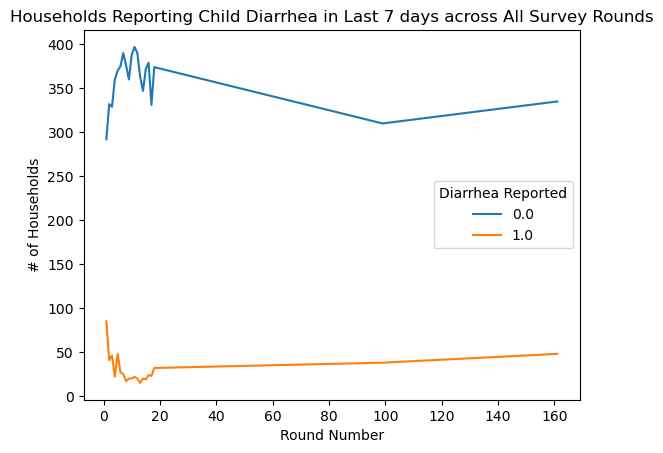

In [55]:
ax = sns.lineplot(data=wg_plot_df,x='bwm_round', y='count', hue='d6a1_7dd_n');
plt.legend(title='Diarrhea Reported')
ax.set(xlabel='Round Number', ylabel='# of Households', 
       title='Households Reporting Child Diarrhea in Last 7 days across All Survey Rounds');

<!-- BEGIN QUESTION -->

**Question 3.5**: Do you observe any particular trends in the reported past 7-day prevalence of child diarrhea across the survey rounds? Think of how its prevalence changes relative to previous survey rounds. Furthermore, discuss potential reasons for the trends you are observing.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

**Question 3.6**: Let's dive deeper into the trends we're observing here. Obtain the *proportion* of households reporting child diarrhea across the survey rounds and store it in `wg_plot_df_mean`. The resulting dataframe should have the `bwm_round` as the index and only 1 column `proportion`, representing the proportion of households reporting child diarrhea in that survey round.


In [67]:
wg_plot_df_mean = relevant_rounds.groupby("bwm_round")["d6a1_7dd_n"].mean().reset_index(name="proportion").set_index("bwm_round")
wg_plot_df_mean

,proportion
bwm_round,
1,0.225464
2,0.109920
3,0.122667
4,0.057592
5,0.114833
6,0.067164
7,0.060241
8,0.043257
9,0.052632


In [68]:
grader.check("q3_6")

q3_6 results: All test cases passed!

The following code blocks are provided for visualization of the tables that you just computed. 

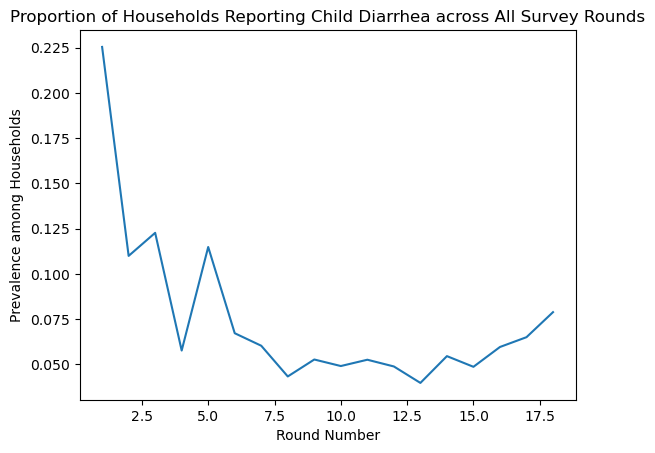

In [69]:
ax = sns.lineplot(x=wg_plot_df_mean.index, y=wg_plot_df_mean['proportion']);
ax.set(xlabel='Round Number', ylabel='Prevalence among Households', 
       title='Proportion of Households Reporting Child Diarrhea across All Survey Rounds');

Now, we will apply the function on a dictionary of diseases already prepared for you. This will generate 5 line plots that describe the average proportion of households reporting a certain disease over the survey rounds.

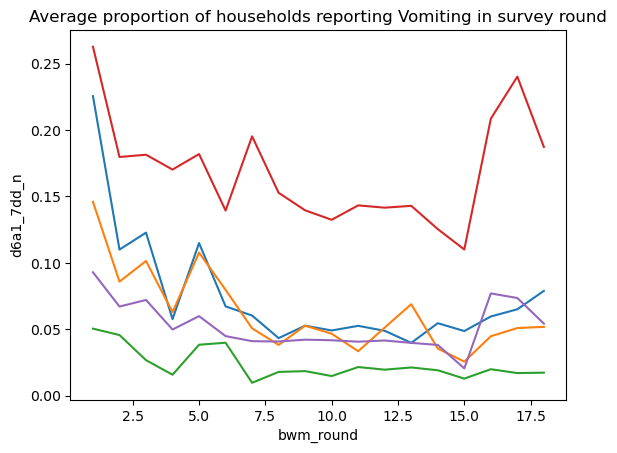

In [70]:
"""
Takes in the condition column and actual name. Outputs plots of average prevalence of 
condition across survey rounds. 
"""
def prevalence_plotter(df, condition_column, condition_name):

    plot_df_mean = df.groupby('bwm_round')[[condition_column]].mean() # SOLUTION
    
    title_string = f"Average proportion of households reporting {condition_name} in survey round"
    ax = sns.lineplot(x=plot_df_mean.index, y=plot_df_mean[condition_column]);
    ax.set(title=title_string);

prevalence_plotter(relevant_rounds, 'd6a1_7dd_n', 'Diarrhea')

conditions = {
'd6d1_7dc_n' : 'Cough',
'd7d2_7dcn_n' : 'Chest Noise',
'd6b_7day_fever_n' : 'Fever',
'd6c_7day_vomiting_n':'Vomiting'}

for condition_column, condition_name in conditions.items():
    prevalence_plotter(relevant_rounds, condition_column, condition_name)


<!-- BEGIN QUESTION -->

**Question 3.7**: Choose one of the plots above and thoroughly reflect on a set of observations in a few sentences. Can you think of why disease prevalence is steadily declining as the number of survey rounds increase? And, what could have caused the sudden uptick in the last rounds? (Hint: Revisit the lecture slides).

_Type your answer here, replacing this text._

<!-- END QUESTION -->

---
## Phase 4: Analyzing the Hawthorne Effect

In this phase of the project we seek to analyze and quantify the [Hawthorne effect](https://en.wikipedia.org/wiki/Hawthorne_effect) mentioned in lecture. In general terms, it is a positive change in the performance of a group of persons taking part in an experiment or study due to their perception of being singled out for special consideration (Collins Dictionary). In our context, we define it as the decrease in disease prevalence attributed to the mere fact that households are *aware of themselves being surveyed.* Let's see if we can put a number to it!

**Question 4.1**: Obtain the proportion of households with reported diarrhea from rounds "99" and "161", similar to the output of question 3.6. Store the results in the dataframe `special_proportions`.

In [72]:
special_proportions = (wg_df.groupby("bwm_round")["d6a1_7dd_n"].mean().reset_index(name="proportion").set_index("bwm_round")).loc[[99, 161], :]
special_proportions.head()

,proportion
bwm_round,
99,0.109195
161,0.125326


In [73]:
grader.check("q4_1")

q4_1 results: All test cases passed!

Let's plot the results you got on the line plot from question 3.7.

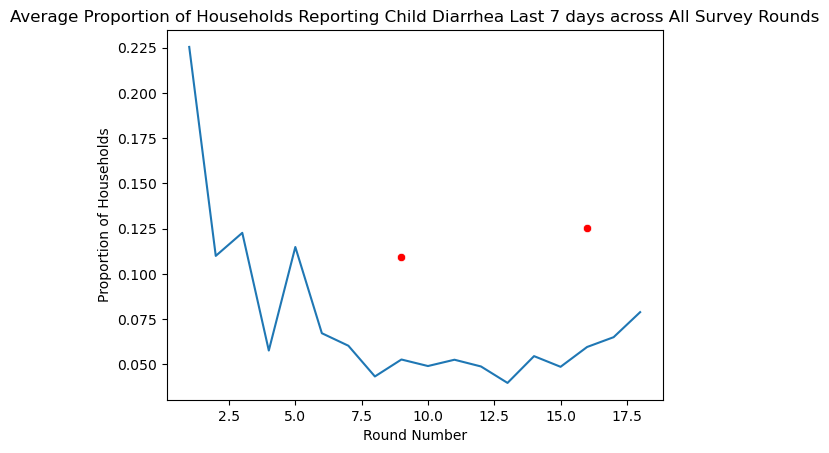

In [74]:
special_proportions_plot = special_proportions.copy()
special_proportions_plot["bwm_round"] = np.array([9, 16])

fig, ax = plt.subplots()
sns.lineplot(x=wg_plot_df_mean.index, y=wg_plot_df_mean['proportion'], ax=ax)
sns.scatterplot(data=special_proportions_plot, x='bwm_round', y='proportion', ax=ax,color='red');
ax.set(title='Average Proportion of Households Reporting Child Diarrhea Last 7 days across All Survey Rounds',
      xlabel='Round Number', ylabel='Proportion of Households');

<!-- BEGIN QUESTION -->

**Question 4.2**: Look at the graph above. The red points are the corresponding control groups 99 and 161. How different are these from the normal group quantitatively? (Feel free to just eyeball it or write some code) Are you surprised by your findings? 

_Type your answer here, replacing this text._

<!-- END QUESTION -->

---
## Phase 5: Analyzing WaterGuard Usage

Now, let's turn our attention to the effect of [WaterGuard](https://www.engineeringforchange.org/solutions/product/waterguard/) usage on disease prevalence across households.

**Question 5.1**: Read in the `BWM_HH_EVDvars.dta` dataset and convert it into a dataframe. 

In [75]:
hh_wg = pd.read_stata("BWM_HH_EVDvars.dta")
hh_wg.head()

,quiz_id,bwm_round,a1_hh_id,a2_spring_id,interview_date,a5_date_interview_day,a5_date_interview_month,a5_date_interview_year,a8_data_entry_id,a9_data_entry_comments,...,child_observed20,child_observed21,child_observed22,spring_id,wave,_merge,h5clcolor,g5WG,G5XH5,date_round
0,1001,1,872002,872,2007-05-09,9,5,2007,NaN,,...,0,0,0,872,2.0,3,1.0,1.0,1.0,2007-05-09
1,1002,1,859009,859,2007-05-09,9,5,2007,NaN,,...,0,0,0,859,1.0,3,1.0,1.0,1.0,2007-05-09
2,1003,1,872007,872,2007-05-09,9,5,2007,NaN,,...,0,0,0,872,2.0,3,0.0,0.0,0.0,2007-05-09
3,1004,1,764029,764,2007-05-09,9,5,2007,NaN,,...,0,0,0,764,3.0,3,0.0,0.0,0.0,2007-05-09
4,1005,1,764016,764,2007-05-09,9,5,2007,NaN,,...,0,0,0,764,3.0,3,0.0,0.0,0.0,2007-05-09


In [76]:
grader.check("q5_1")

q5_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 5.2**: What does each row of `hh_wg` contain? What does it say about the granularity (or the level of aggregation)? How does it compare to the dataframe used in phase 1-4?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

**Question 5.3:** How many households appear in each survey round? 

Hint: The resulting dataframe should have two columns `bwm_round` and `a1_hh_id`. 

In [80]:
hh_round = hh_wg.groupby("bwm_round")["a1_hh_id"].count().reset_index().set_index("bwm_round")
hh_round.head()

,a1_hh_id
bwm_round,
1,156
2,153
3,151
4,153
5,162


In [81]:
grader.check("q5_3")

q5_3 results: All test cases passed!

**Question 5.4:** In each round, how many households have validated usage of WaterGuard? 

Hint: The column with the obscure name of `G5XH5` might be of interest to you - it's a dummy variable for validated WG usage! 
The resulting dataframe should have three columns: `bwm_round`, `Validated WaterGuard Usage` and `Count`.

In [91]:
hh_round_vld = hh_wg.groupby(["bwm_round","G5XH5"])["a1_hh_id"].count().reset_index(name="Count").rename(columns={"G5XH5": "Validated WaterGuard Usage"})
hh_round_vld.head()

,bwm_round,Validated WaterGuard Usage,Count
0,1,0.0,126
1,1,1.0,30
2,2,0.0,123
3,2,1.0,30
4,3,0.0,107


In [92]:
grader.check("q5_4")

q5_4 results: All test cases passed!

Now we turn to a truly interesting part of the survey: How does the promotion of WaterGuard affect the actual use of the product? You might have noticed the `assign_wg` column in both of our datasets: This denotes whether or not a given household has been promoted WG as a product. Promotion includes free samples, encouragement scripts, and follow-ups on water quality. The encoding is as follows: 

- `assign_wg` = 0 is a control household with no WG Promotion.
- `assign_wg` = 1 is a household with WG Promotion.

Here's an example of how a household with WG promotion looks like across all survey rounds:  

In [93]:
hh_wg[hh_wg['a1_hh_id']== 872002][['bwm_round', 'assign_wg']]

,bwm_round,assign_wg
0,1,1.0
219,2,1.0
376,3,1.0
518,4,1.0
674,5,1.0
834,6,1.0
969,7,1.0
1159,8,1.0
1271,9,1.0
1483,10,1.0


**Question 5.5:** Select the `bwm_round`, `G5XH5`, `assign_wg` columns from our `hh_wg` dataset. Then rename `G5XH5` as `validated_wg` and `assign_wg` as `promoted_wg`, respectively. Only include the normal survey rounds (i.e. not including rounds 99 and 161). Assign your results to `df_55`.

In [94]:
df_55 = hh_wg[(hh_wg["bwm_round"] != 99) & (hh_wg["bwm_round"] != 161)][["bwm_round", "G5XH5", "assign_wg"]]
df_55 = df_55.rename({"G5XH5": "validated_wg", "assign_wg": "promoted_wg"}, axis=1)
df_55

,bwm_round,validated_wg,promoted_wg
0,1,1.0,1.0
1,1,1.0,1.0
2,1,0.0,0.0
3,1,0.0,0.0
4,1,0.0,1.0
...,...,...,...
2948,18,0.0,1.0
2949,18,0.0,0.0
2950,18,0.0,1.0
2951,18,0.0,1.0


In [95]:
grader.check("q5_5")

q5_5 results: All test cases passed!

**Question 5.6:** How does validated Waterguard usage vary in our treatment and control groups across all survey rounds? Use `df_55` to find out the average proportion of households with validated WG usage per round for the treatment and control group respectively. Your resulting dataframe should have 3 columns: `bwm_round` (round number), `promoted_wg` (binary column indicating treatment or control group), and `proportion` (proportion of households using waterguard for the treatment/control group in that round). Assign your results to `df_56`.

In [99]:
df_56 = df_55.groupby(["bwm_round", "promoted_wg"])["validated_wg"].mean().reset_index(name="proportion")
...
df_56.head()

,bwm_round,promoted_wg,proportion
0,1,0.0,0.060976
1,1,1.0,0.337838
2,2,0.0,0.064103
3,2,1.0,0.333333
4,3,0.0,0.080000


In [ ]:
grader.check("q5_6")

We plot the data below.

In [ ]:
ax = sns.lineplot(data=df_56,x='bwm_round', y='proportion', hue='promoted_wg');
plt.legend(title='Treatment Group')
ax.set(xlabel='Round Number', ylabel='Proportion of WaterGuard Usage', 
       title='Validated WaterGuard Usage for Treatment vs Control Groups across different rounds');

<!-- BEGIN QUESTION -->

**Question 5.7:** Does the plot above surprise you? Did you expect the effect of WG promotion to be larger, smaller, or follow another trend curve than what we witness above? (2-3 sentences should suffice.)

_Type your answer here, replacing this text._

<!-- END QUESTION -->

___
## Congratulations!

You just finished the longest lab in Econ 148. Give yourself a clap on the shoulder and sit back and appreciate your following accomplishments:

- You performed a stellar EDA of the Main Rural Project Spring Protection Study, a real-world dev-econ project!
- You delved deep into a truly complex survey, and put yourself into the situation of both the interviewer and the one being interviewed!
- With your understanding of the survey, you analysed the prevalence of 5 serious diseases across 2000+ households, and even built a function to do so!
- You understood and analysed the Hawthorne effect, and managed to quanitfy the extent to which it was present in our study data.
- You set yourself up for a further analysis of diarrhea prevalence through examining the usage and promotion of WaterGuard.
- And much more!
What a lab!

<a id='appendix_1'></a>
## Appendix 1: Relevant Column Sections

Columns to register children born within the past 2 weeks

- 'c3_1_child_id',
 'c3_2a_name1',
 'c3_2b_name2',
 'c3_3_gender',
 'c3_4_doa_day',
 'c3_4_doa_month',
 'c3_4_doa_year',
 'c3_5_dob_day',
 'c3_5_dob_month',
 'c3_5_dob_year',
 'c3_6_age_months',
 'c3_6_age_weeks',
 'c3_6_age_years',
 'c3_7_verified',
 'c3_7_verified_other',

General Child Health History columns

Note: There are 10x sheets of these in the original survey, one for each child's health condition. They ask questions on whether or not child has had (during the past week) symptoms of diarrhea, blood in stool, fever, vomiting, constant cough, and/or weakness. One of the reasons for the amount of the columns is that the survey asks for daily symptom data.

-  'd1_child_id',
 'd3_clinic_card',
 'd4a_dob_day',
 'd4a_dob_month',
 'd4a_dob_year',
 'd4b_age_months',
 'd4b_age_weeks',
 'd4b_age_years',
 'd5a_main_other_relation',
 'd5a_main_relation',
 'd5b_hist_other_relation',
 'd5b_hist_relation',

- Diarrhea Section: 'd6a1_7day_diarrhea',
 'd6a2_7day_blood_in_stool',
 'd6b_7day_fever',
 'd6c_7day_vomiting',
 'd6d1_7day_cough',
 'd6d2_7day_chest_noise',
 'd6d3_7day_dif_breathing',
 'd6e_7day_weakness','d7a1_num_diarrhea',
 'd7a2_num_blood_in_stool',
 'd7b_num_fever',
 'd7c_num_vomiting',
 'd7d1_num_cough',
 'd7d2_num_chest_noise',
 'd7d3_num_dif_breathing',
 'd7e_num_weakness',
 'd8a1_unit_diarrhea',
 'd8a2_unit_blood_in_stool',
 'd8b_unit_fever',
 'd8c_unit_vomiting',
 'd8d1_unit_cough',
 'd8d2_unit_chest_noise',
 'd8d3_unit_dif_breath',
 'd8e_unit_weakness',
 'd9a1_today_diarrhea',
 'd9a2_today_blood_in_stool',
 'd9b_today_fever',
 'd9c_today_vomiting',
 'd9d1_today_cough',
 'd9d2_today_chest_noise',
 'd9d3_today_dif_breathing',
 'd9e_today_weakness',
 'd10a1_yest_diarrhea',
 'd10a2_yest_blood_in_stool',
 'd11a1_2day_diarrhea',
 'd11a2_2day_blood_in_stool',
 'd12a1_3day_diarrhea',
 'd12a2_3day_blood_in_stool',
 'd13a1_4day_diarrhea',
 'd13a2_4day_blood_in_stool',
 'd14a1_5day_diarrhea',
 'd14a2_5day_blood_in_stool',
 'd15a1_6day_diarrhea',
 'd15a2_6day_blood_in_stool',
 'd16a1_7day_diarrhea',
 'd16a2_7day_blood_in_stool',
 'd17b_numdays_fever',
 'd17c_numdays_vomiting',
 'd17d1_numdays_cough',
 'd17d2_numdays_chest_noise',
 'd17d3_numdays_dif_breathing',
 'd17e_numdays_weakness',
 'd18_stool',
 'd18_stool_other',
 'd19_drink_from_respondent',
 'd20_tears',
 'd21_urine',
 'd22_missed_school',
 'd23_hospital',
 'd24_breastfeeding',
 'd25_consent',

Child Examination Columns

Note: This section is filled out if child had diarrhea on the same day as the survey - after filling out section D, the one above. Each entry is for a unique child_id in the household. There can be multiple per visit (e.g several children have diarrhea in the household at the same time.)

- 'e1_1_child_id',
 'e1_2_mucous_membrane',
 'e1_3_nasal_flaring',
 'e1_4_acc_musc',
 'e1_5_fontanels',
 'e1_6_temp',
 'e1_7_resp_num',
 'e1_7_resp_sleep',
 'e1_7_resp_time',
 'e1_8_turgor',
 'e1_9_alertness',
 'e1_10_pulse_num',
 'e1_10_pulse_sleep',
 'e1_10_pulse_time',
 'e1_11_unable_to_assess',

Child Information Section

This section aims to map an overview of the two previous sections, registering whether or not there was a child health and/or examination section filled out for every individual child in the household. It could be thought of as a 'history' chart for a given household over the time of the survey. (ERIC)

- 'fa_id',
 'fb1_child_alive',
 'fb2_status_duplicate_id',
 'fc_history_taken',
 'fc_history_taken_explain',
 'fd_exam_done',
 'fd_exam_done_explain',
 'fe_clinic_card',
 'ff_card_measles',
 'fg_vaccinations',
 'fh_vacc_age',
 'fi_vacc_public',
 'f11_1_child_id',
 'f11_2_diarrhea',
 'f11_3_num_of_days',

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)